# PPO, R-PPO and VAE comparison

## Frauds in the dataset
We compute how much money a fraudster is able to collect with a card in the simulator.

In [ ]:
from parameters import CardSimParameters

p = CardSimParameters.paper_params()
fraudulent_cards, terminals, transactions = p.get_simulation_data()

Sourcing DCPC data


INFO:cardsim.cardsim.Cardsim:Sourcing DCPC data


Sourcing successful; formatting data


INFO:cardsim.cardsim.Cardsim:Sourcing successful; formatting data


DCPC data sourcing and formatting complete


INFO:cardsim.cardsim.Cardsim:DCPC data sourcing and formatting complete


Generating payer profiles for 20000 payers


INFO:cardsim.cardsim.Cardsim:Generating payer profiles for 20000 payers


Generating payee profiles for 2000 payees


INFO:cardsim.cardsim.Cardsim:Generating payee profiles for 2000 payees


In [ ]:
from parameters import CardSimParameters, Parameters

params = Parameters(cardsim=CardSimParameters.paper_params())
env = params.create_env()
banksys = env.system

In [ ]:
frauds = [t for t in transactions if t.is_fraud]
frauds.sort(key=lambda t: t.timestamp)
print(len(frauds))
n_cards = set(t.card_id for t in frauds)
print(len(n_cards))

In [ ]:
import matplotlib.pyplot as plt

amounts = [t.amount for t in transactions]
plt.boxplot(amounts, vert=False)

In [ ]:
plt.boxplot(amounts, vert=True, showfliers=False)


In [6]:
from tqdm import tqdm

blocked_cards = set()
frauds_amounts = list[float]()

for trx in tqdm(frauds):
    if trx.card_id in blocked_cards:
        continue
    if banksys.process_transaction(trx):
        blocked_cards.add(trx.card_id)
        frauds_amounts.append(0.0)
    else:
        undetected_frauds.append(trx)

100%|██████████| 158171/158171 [03:48<00:00, 693.17it/s]  


In [7]:
len(undetected_frauds)

3205

## Score over training time

In [1]:
import numpy as np

anomaly = True

logdirs = {
    "VAE": "logs/exp-final/vae",
    "PPO": "logs/exp-final/ppo",
    "R-PPO": "logs/exp-final/rppo",
}


def moving_average(data, window_size=100):
    """Compute the moving average of a 1D array."""
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


In [2]:
import os
from plots import Experiment

from parameters import Parameters, serialize_unknown





logs/exp-final/vae
There are 4 runs in VAE
logs/exp-final/ppo
There are 4 runs in PPO
logs/exp-final/rppo
There are 4 runs in R-PPO


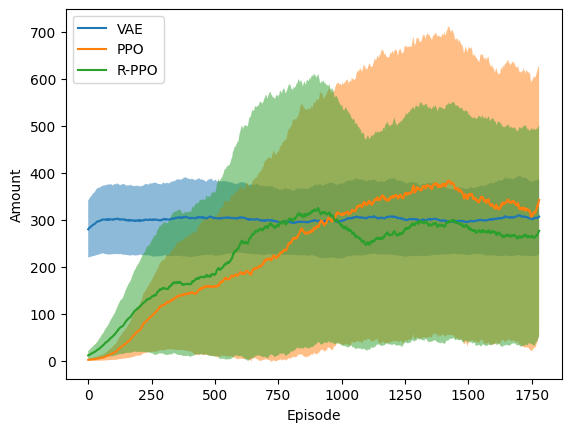

In [3]:
import matplotlib.pyplot as plt
from plots import Experiment


import numpy as np
import matplotlib.pyplot as plt

# First, collect all sequences to determine the max length
all_means = {}
all_stds = {}
max_len = 2500

# First pass to find max length
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    mean, std = exp.mean_std_amounts_over_time
    mean = moving_average(mean)
    std = moving_average(std)
    all_means[label] = mean
    all_stds[label] = std
    max_len = max(max_len, len(mean))

# Now pad all sequences to max_len with NaNs
for label in logdirs:
    mean = all_means[label]
    std = all_stds[label]
    padded_mean = np.full(max_len, np.nan)
    padded_std = np.full(max_len, np.nan)
    padded_mean[:len(mean)] = mean
    padded_std[:len(std)] = std

    # Compute 95% CI
    ci95 = 1.96 * (padded_std / exp.n_runs**0.5)
    x = np.arange(max_len)
    plt.plot(x, padded_mean, label=label)
    plt.fill_between(x, padded_mean - ci95, padded_mean + ci95, alpha=0.5)

plt.xlabel("Episode")
plt.ylabel("Amount")
#plt.ylim(top=300)
plt.legend()
plt.savefig("amount-over-time_anomaly.svg")



In [17]:
import numpy as np
import pandas as pd

# Dictionary to store results
results = {
    "Label": [],
    "Episodes": [],
    "Mean": [],
    "Variance": []
}

for label, logdir in logdirs.items():
    print(logdir)
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    amounts = exp.amounts_over_time  # shape: (n_runs, n_episodes)

    for episodes in [1000, 2000, 3000]:
        if amounts.shape[1] >= episodes:
            cumulated = np.sum(amounts[:, :episodes], axis=1)
            mean = np.mean(cumulated)
            var = np.var(cumulated, ddof=1)  # sample variance

            results["Label"].append(label)
            results["Episodes"].append(episodes)
            results["Mean"].append(mean)
            results["Variance"].append(var)
        else:
            print(f"{label} has fewer than {episodes} episodes. Skipping.")

# Convert to DataFrame for pretty printing or export
results_df = pd.DataFrame(results)
results_df

logs/ULB/exp-retrain/True-anomaly/vae
There are 4 runs in VAE
logs/ULB/exp-retrain/True-anomaly/ppo/
There are 4 runs in PPO
logs/ULB/exp-retrain/True-anomaly/rppo
There are 3 runs in R-PPO


,Label,Episodes,Mean,Variance
0,VAE,1000,37460.375030,3.038530e+06
1,VAE,2000,85986.827629,3.690370e+07
2,VAE,3000,137945.270048,4.790701e+07
3,PPO,1000,14175.389977,5.873454e+07
4,PPO,2000,78943.959916,1.751420e+08
5,PPO,3000,163240.794871,4.086972e+08
6,R-PPO,1000,32774.773258,8.549150e+07
7,R-PPO,2000,72064.593228,5.001552e+08
8,R-PPO,3000,124008.156509,7.816894e+08


## Number of transactions per card over time

There are 15 runs in VAE
There are 14 runs in PPO


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (14,) + inhomogeneous part.

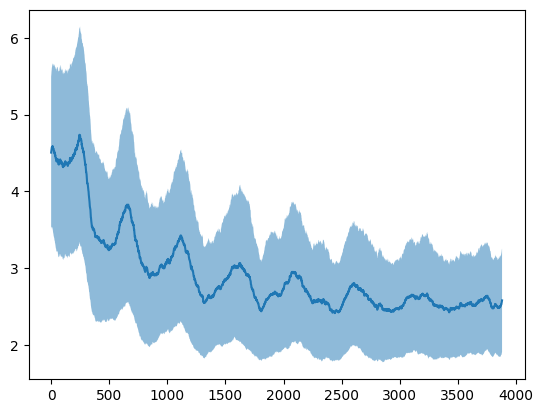

In [68]:
import matplotlib.pyplot as plt
from plots import Experiment


for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    data = exp.n_transactions_over_time
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    mean = moving_average(mean, window_size=100)[:-20]
    std = moving_average(std, window_size=100)[:-20]
    # Compute the 95% confidence interval from the STD
    ci95 = 1.96 * (std / exp.n_runs**0.5)
    plt.plot(mean, label=label)
    plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.5)

plt.xlabel("Episode")
plt.ylabel("Number of transactions per card")
plt.legend()
plt.savefig("n-transactions.svg")

In [ ]:
experiment = Experiment.load(logdir)
label, max(experiment.n_transactions_over_time[0])

## Total amount collected

C:\Users\dalun\AppData\Local\Temp\ipykernel_31380\2554115465.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(amounts, labels=labels, showmeans=True)


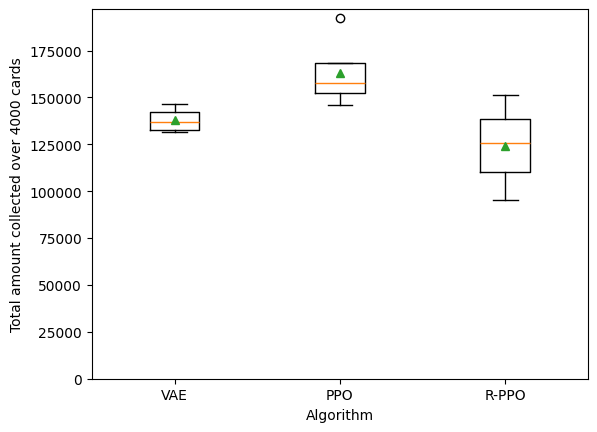

In [10]:
import matplotlib.pyplot as plt
from plots import Experiment

amounts = []
labels = []
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    amounts.append(exp.total_amounts)
    labels.append(label)

plt.boxplot(amounts, labels=labels, showmeans=True)
plt.ylabel("Total amount collected over 4000 cards")
plt.xlabel("Algorithm")
#plt.grid(axis="y")
plt.ylim(bottom=0)  #0  1_000_000
plt.savefig("boxplot-amounts_Anomaly.svg")
plt.show()


###### Plot amounts boxplots


import matplotlib.pyplot as plt
from plots import Experiment

amounts = []
labels = []
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    amounts.append(exp.amounts_over_time)
    print(amounts)
    labels.append(label)

plt.boxplot(amounts, labels=labels, showmeans=True)
plt.ylabel("Total amount collected over 4000 cards")
plt.xlabel("Algorithm")
#plt.ylim(bottom=0)  # Set lower y-axis limit to 0
plt.savefig("boxplot-amounts.svg")
plt.show()


In [ ]:
exp.get_actions()

In [ ]:
exp.amounts_over_time[0]